差が0.01%以上ある行数: 220
           Date  Close  Change %  Calculated Change %
0    1987-02-12  182.4     16.25                 0.00
2325 1996-07-11   79.5     -0.63                -0.62
2385 1996-10-07   80.3      0.38                 0.37
2388 1996-10-11   79.5     -0.63                -0.62
6835 2014-11-25   63.6     -0.63                -0.62
8639 2022-04-18  149.6     -0.24                -0.27
8640 2022-04-19  151.2      1.02                 1.07
8641 2022-04-20  151.7      0.34                 0.33
8642 2022-04-21  151.0     -0.42                -0.46
8643 2022-04-22  150.9     -0.11                -0.07
=== データ概要 ===
レコード数: 9201
期間: 1987-02-13 00:00:00 から 2024-08-01 00:00:00 (13684日間)

=== 価格データの範囲 ===
Close: 最小=33.0, 最大=305.9
Open: 最小=33.0, 最大=309.8
High: 最小=33.2, 最大=311.8
Low: 最小=32.2, 最大=303.9

=== 基本統計量 ===
                                Date        Close         Open         High  \
count                           9201  9201.000000  9201.000000  9201.000000   
mean   2005-10-22

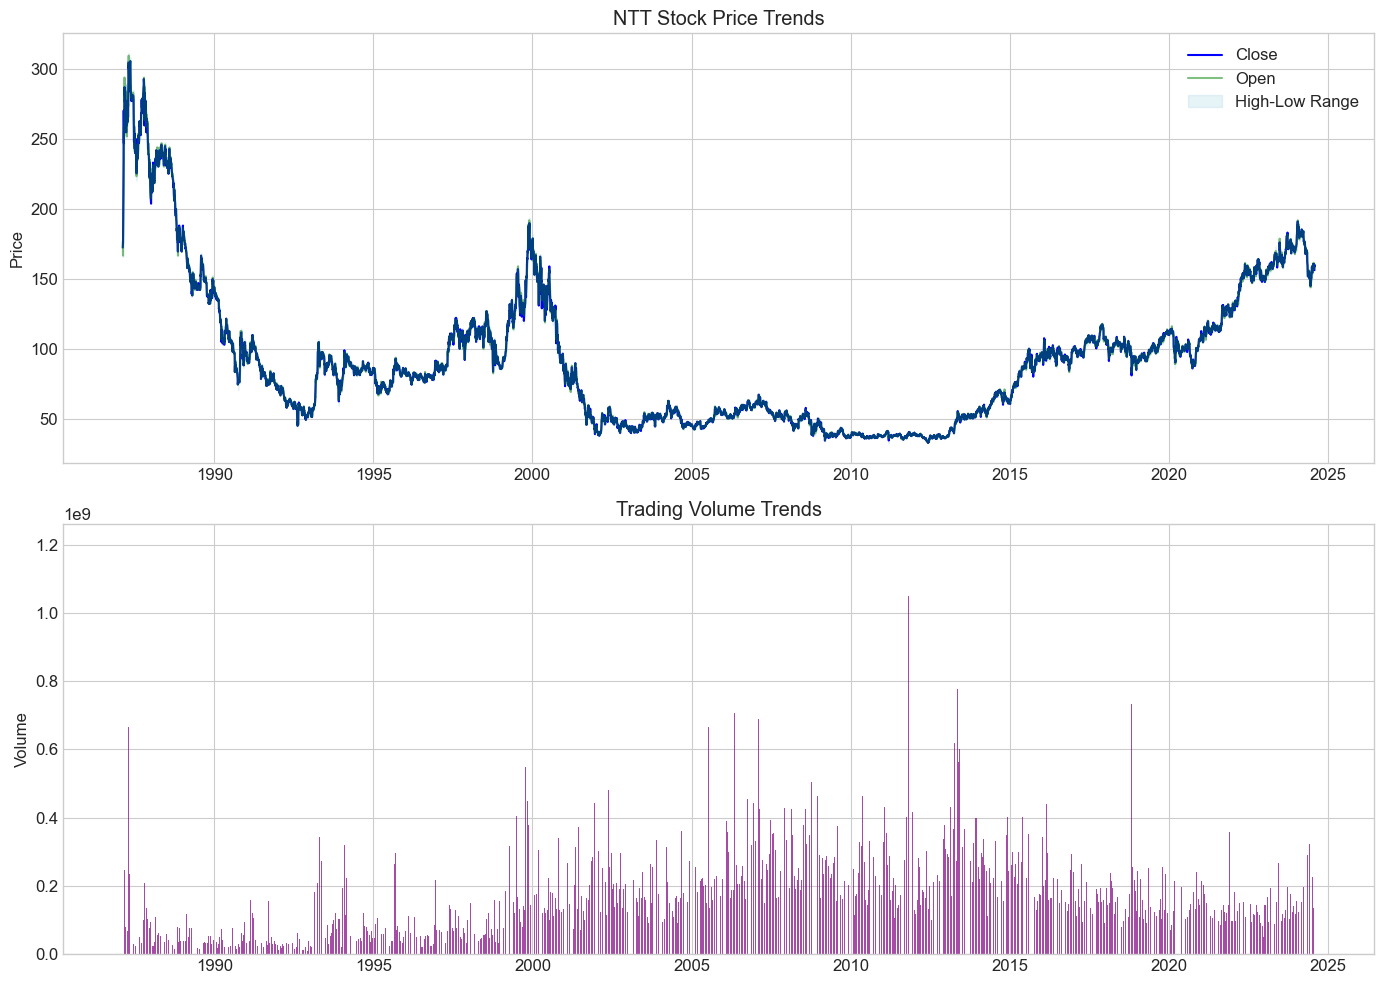

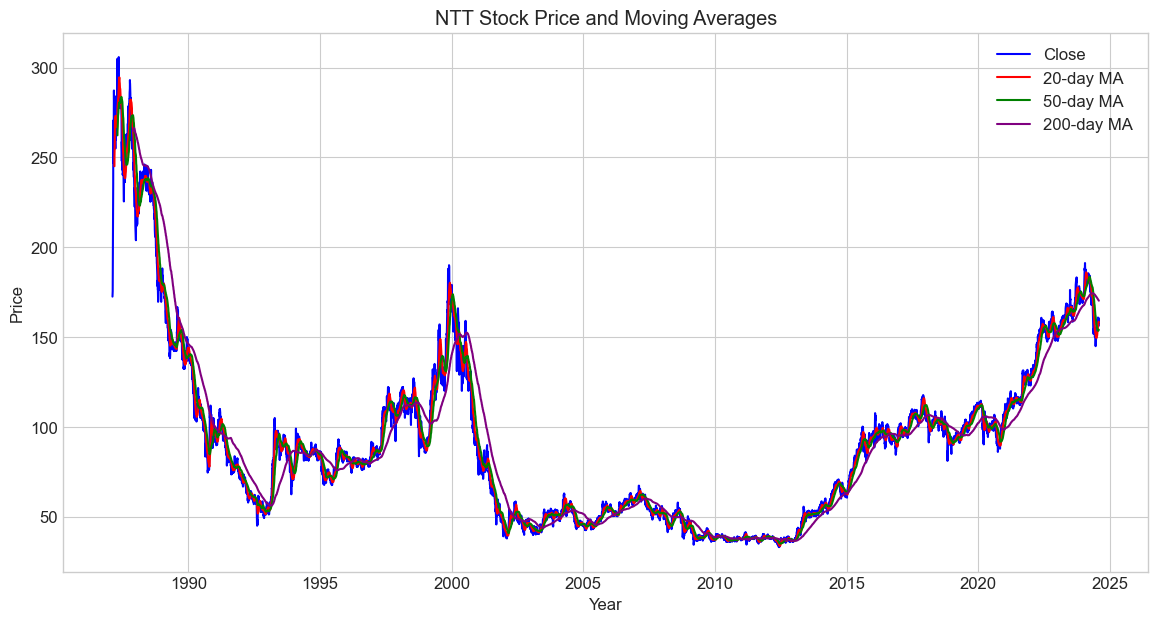

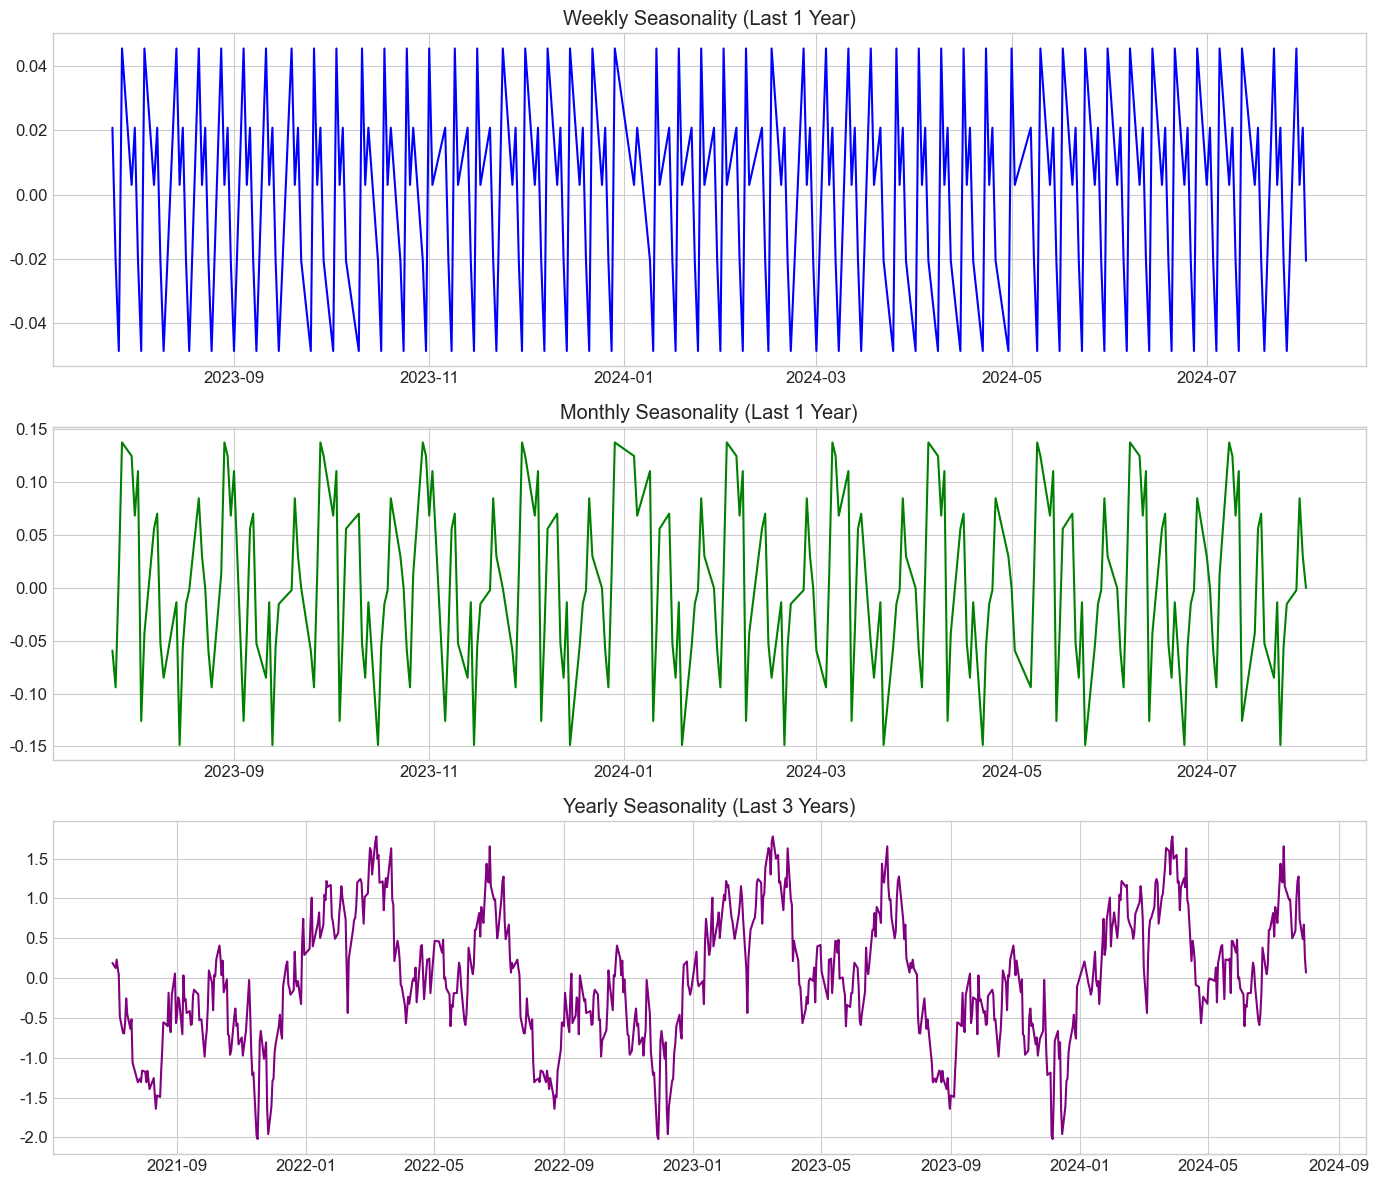

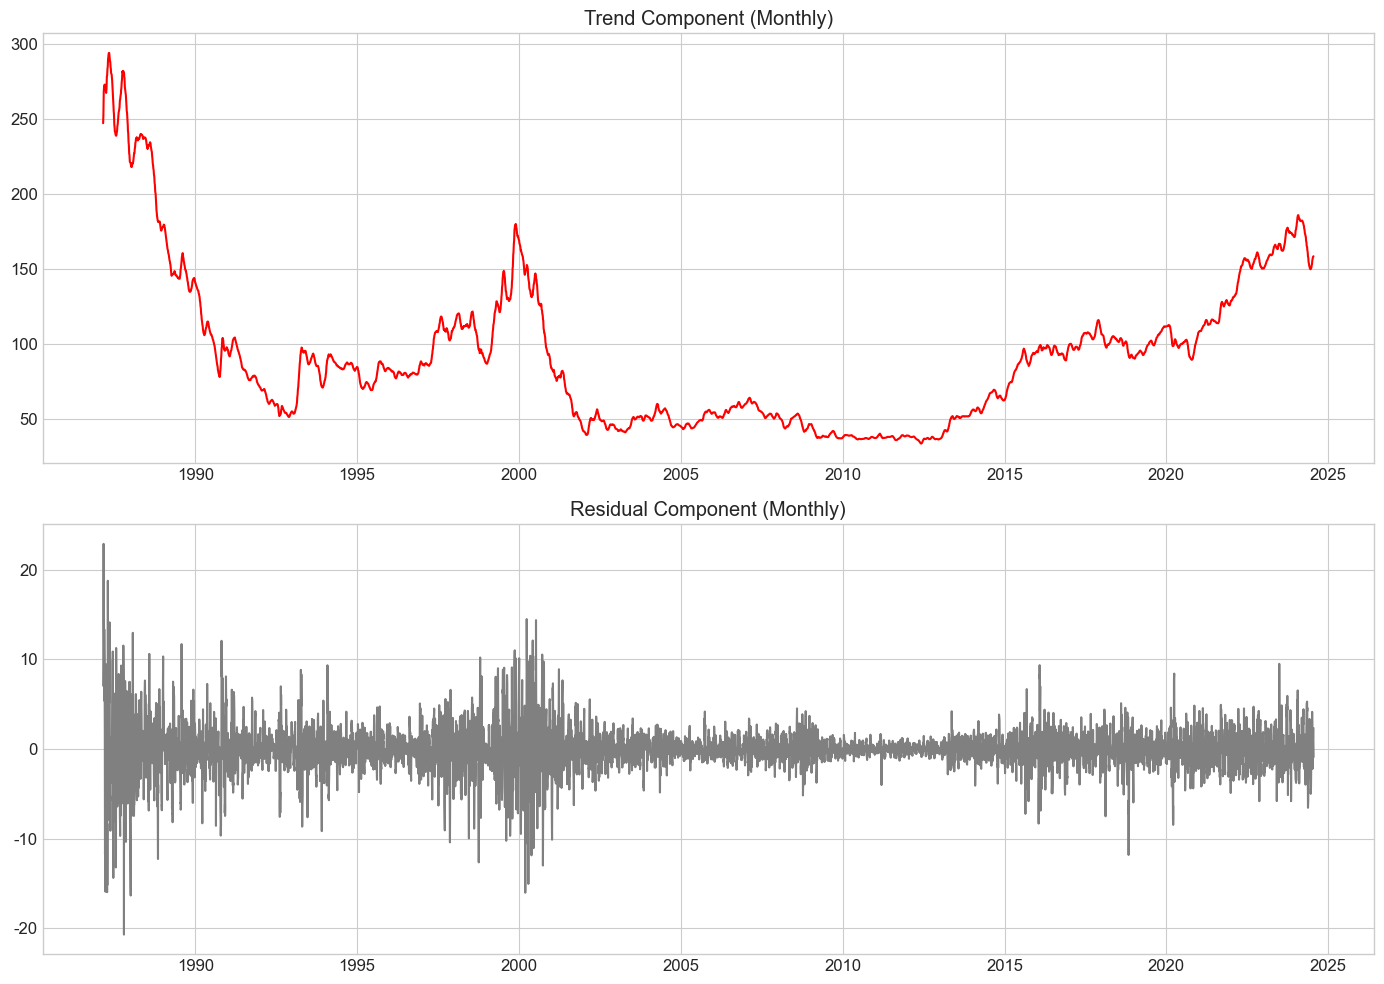

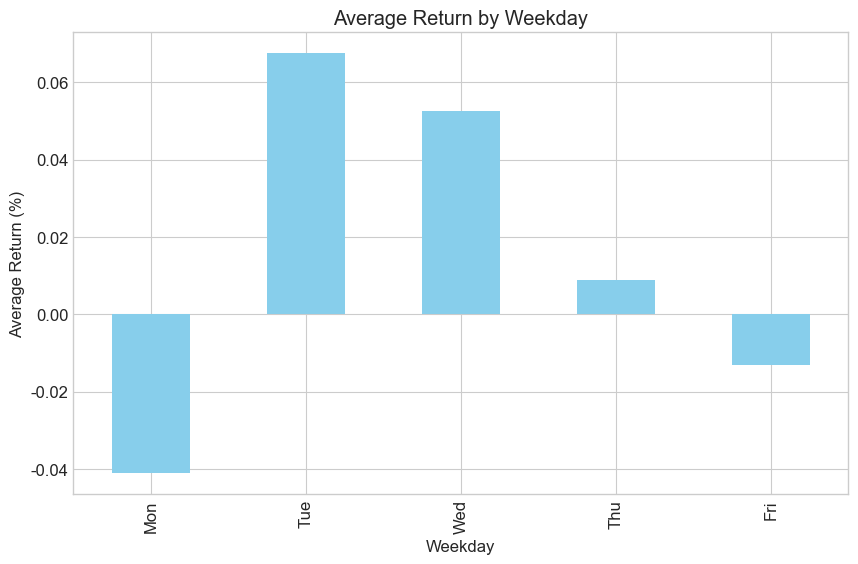

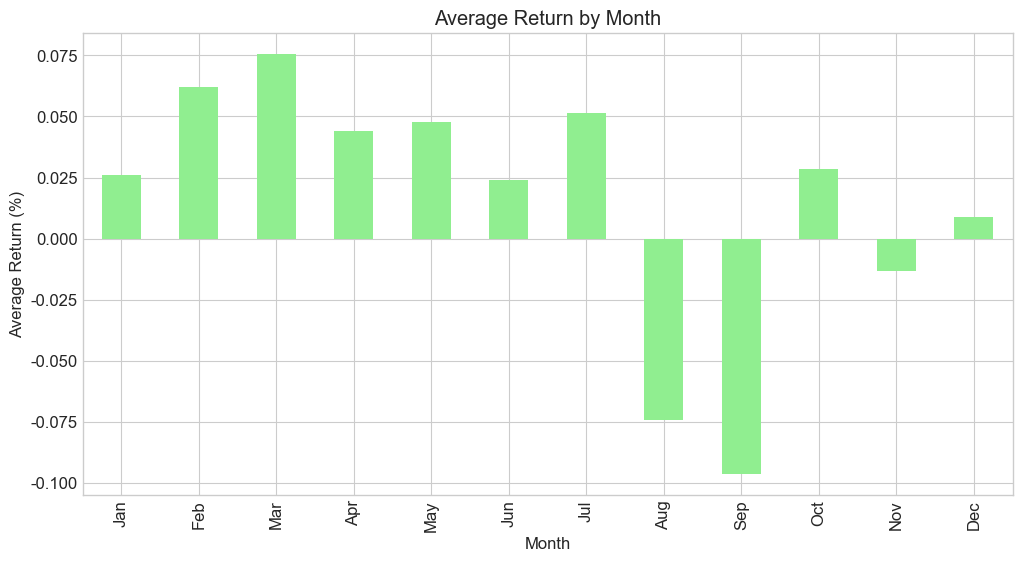

=== 曜日別統計 ===
             Close             Change %                
              mean        std      mean       std count
Weekday                                                
0        93.026801  50.950177 -0.041182  2.044888  1735
1        92.063110  50.152341  0.067458  1.778094  1865
2        92.001070  50.301982  0.052578  1.832201  1870
3        91.915925  50.469354  0.008879  1.891406  1865
4        91.909110  50.434923 -0.013167  1.799830  1866

=== 月別統計 ===
           Close             Change %                
            mean        std      mean       std count
Month                                                
1      88.534375  45.550102  0.025909  1.755529   704
2      90.620388  48.187607  0.062247  1.824434   721
3      94.392109  53.761851  0.075524  2.086297   811
4      94.196026  53.729539  0.044013  1.829148   780
5      95.027882  53.426270  0.047882  1.782521   746
6      94.592383  52.351407  0.023993  1.662955   814
7      94.821455  49.787269  0.051393 

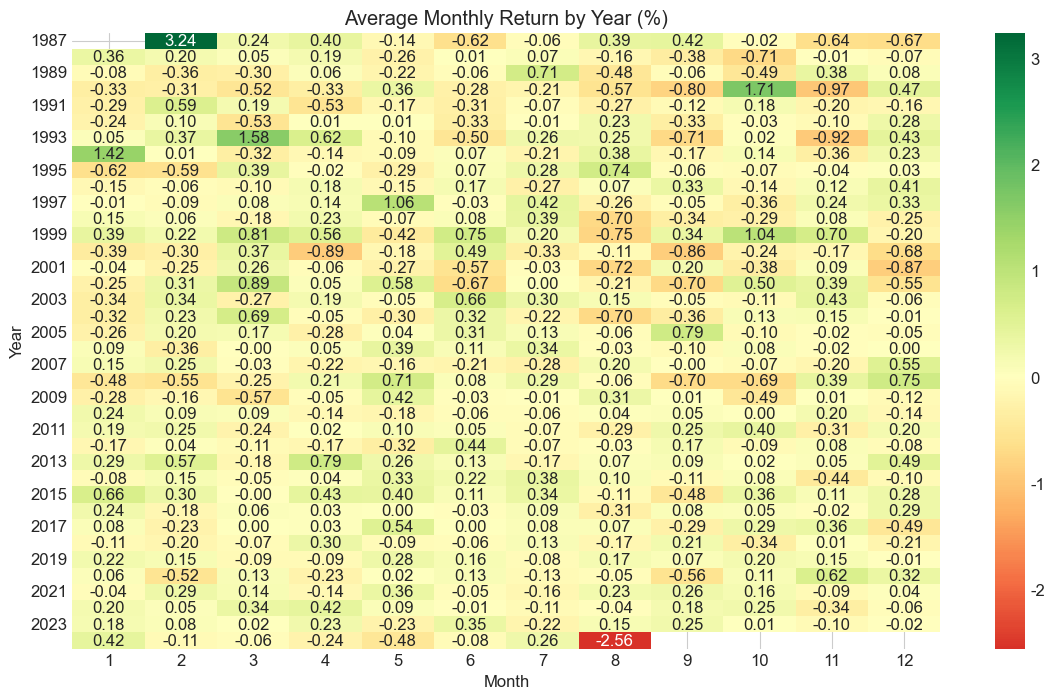

日次リターンのヒストグラム


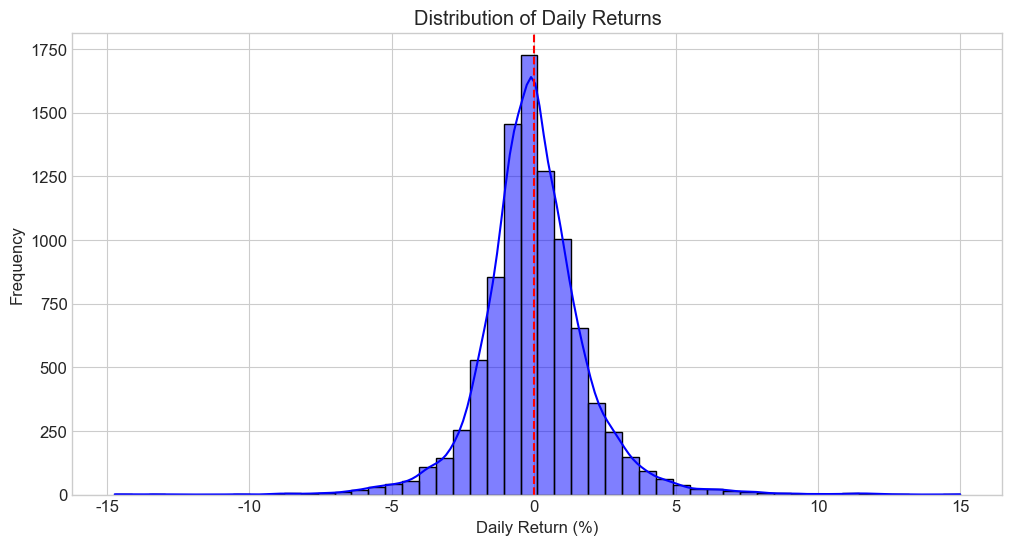

=== リターンの基本統計量 ===
count    9201.000000
mean        0.015723
std         1.869167
min       -14.740000
25%        -0.940000
50%         0.000000
75%         0.900000
max        15.000000
Name: Change %, dtype: float64
正規性の確認（Q-Qプロット）


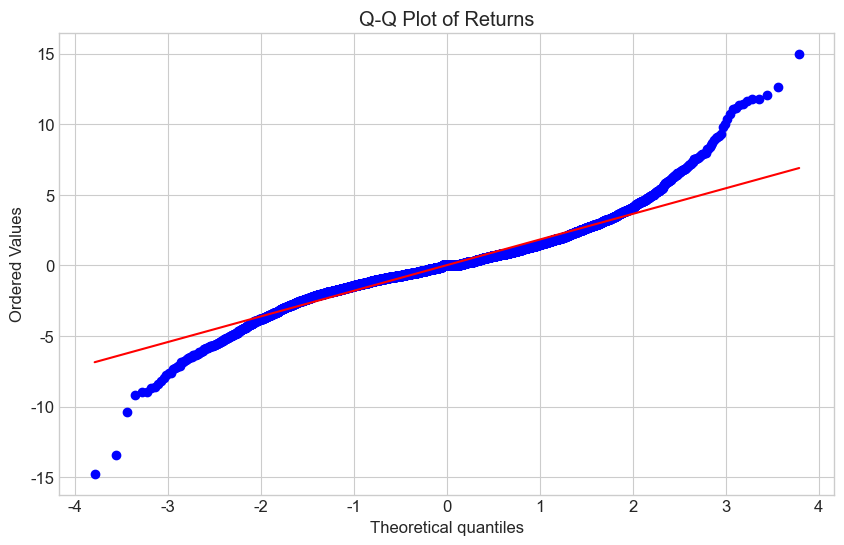

ボラティリティの推移（20日間の標準偏差）


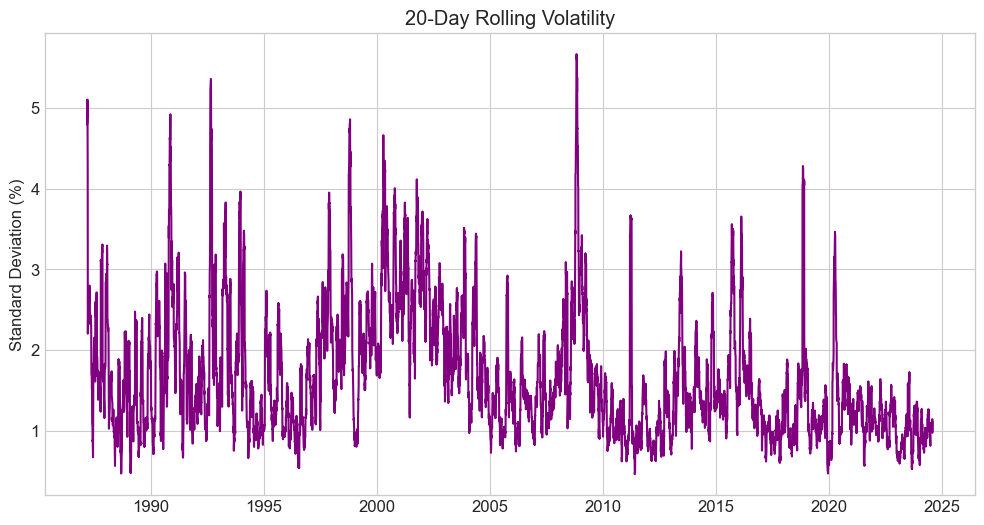

自己相関分析


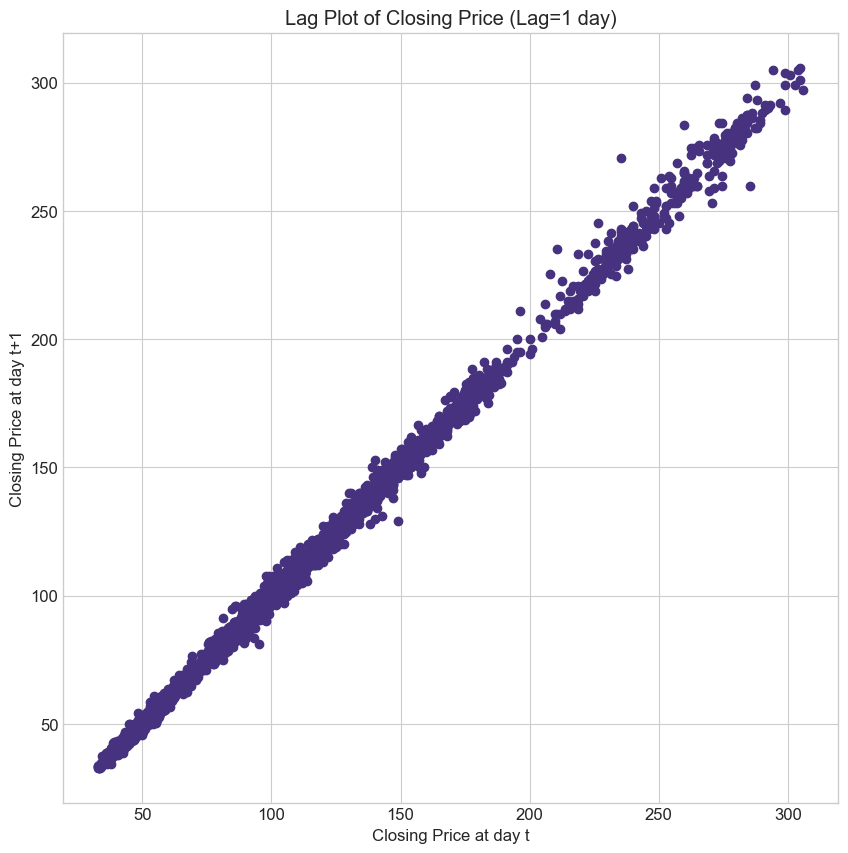

<Figure size 1200x600 with 0 Axes>

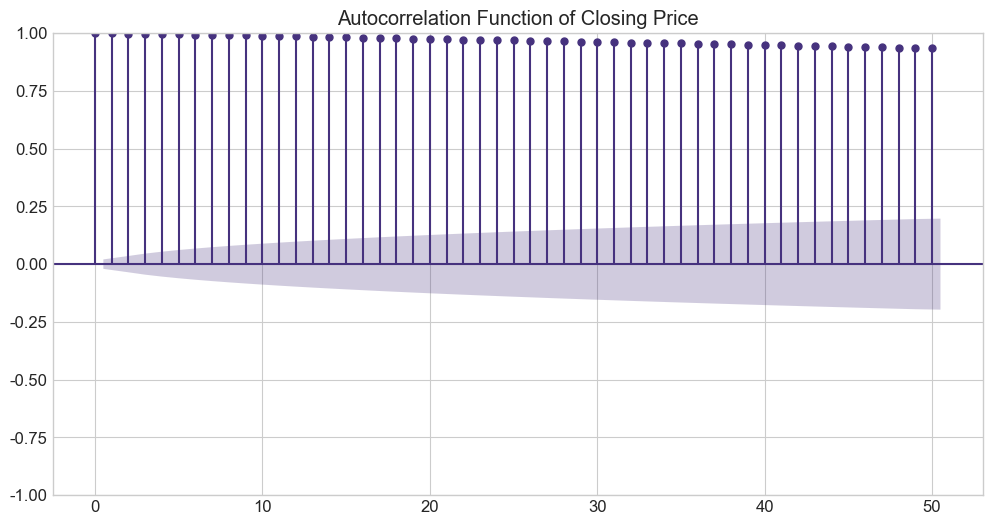

<Figure size 1200x600 with 0 Axes>

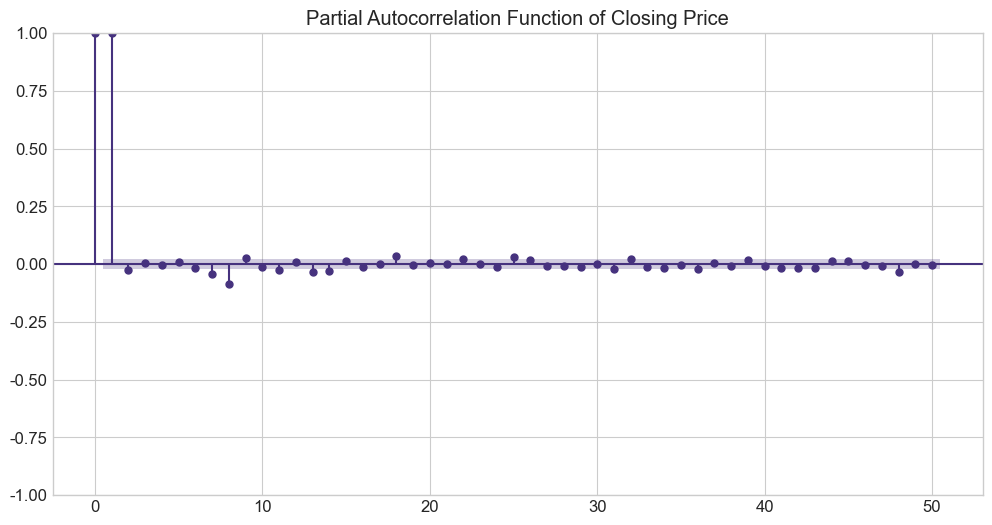

<Figure size 1200x600 with 0 Axes>

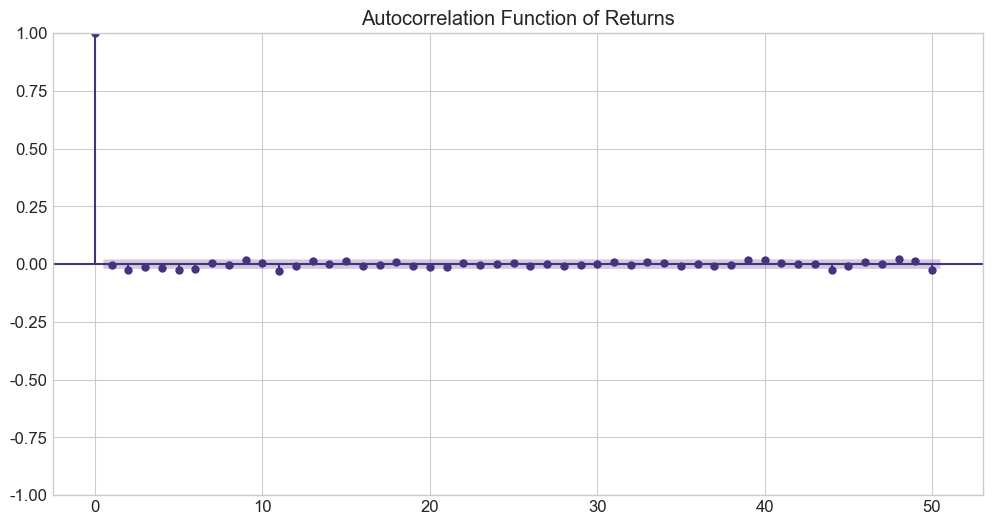

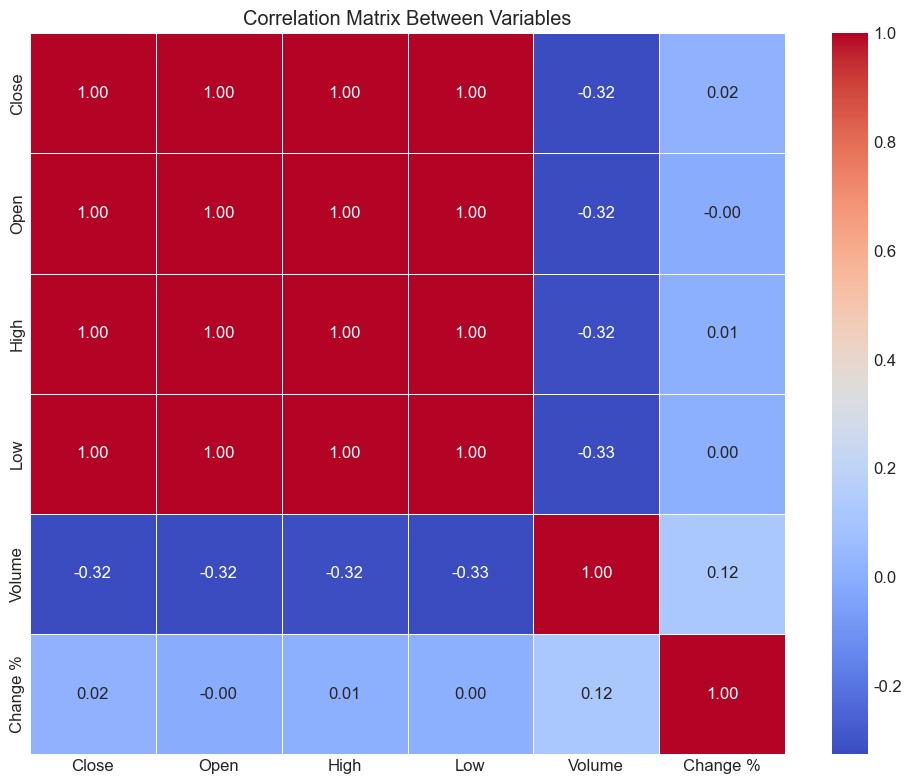

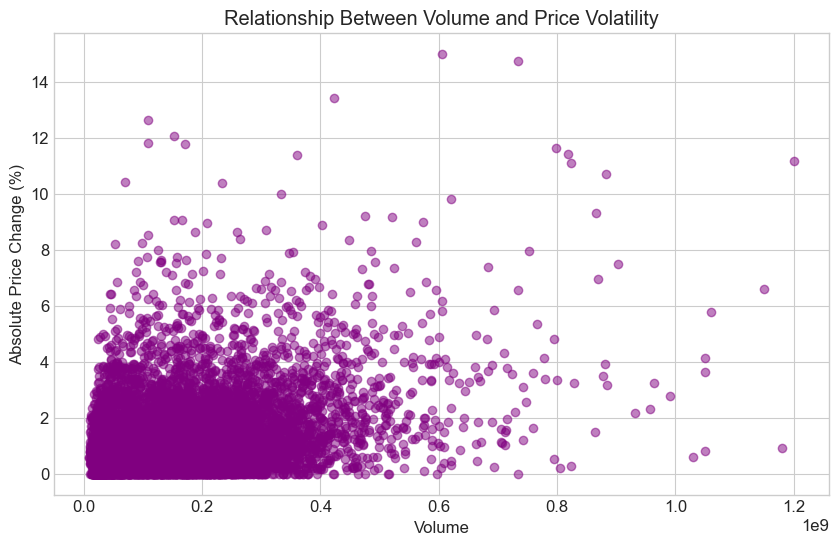

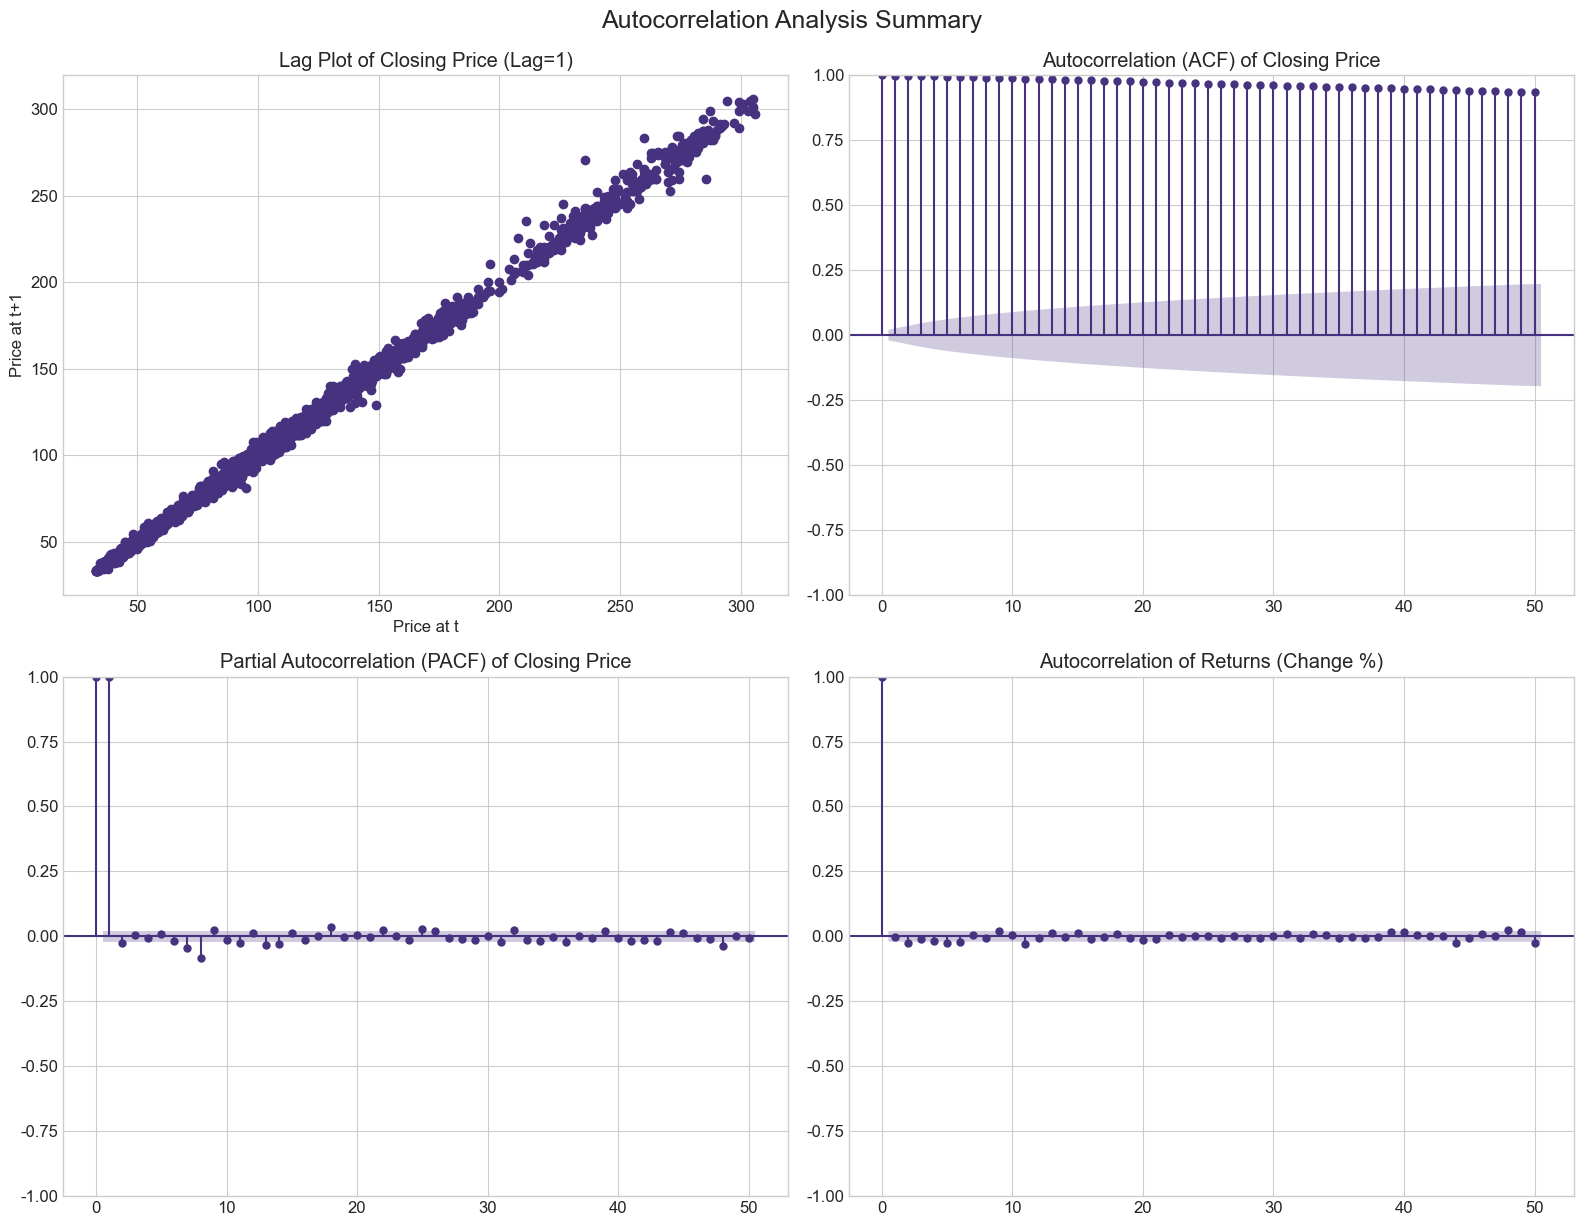


処理済みデータを保存しました。


In [8]:
# NTT株価データの探索的データ分析（EDA）

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
import matplotlib as mpl
import matplotlib.font_manager as fm

# 日本語フォントパスを直接指定
font_path = 'C:/Windows/Fonts/msgothic.ttc'  # MS Gothicフォント
font_prop = fm.FontProperties(fname=font_path)

# 日本語フォント設定を適用
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['MS Gothic']
plt.rcParams['axes.unicode_minus'] = False  # マイナス記号を正しく表示

# グラフの設定
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12



# データ読み込みと前処理
def load_and_preprocess_data():
    # データ読み込み
    df = pd.read_csv(r"C:\Users\Take\python\ntt-stock-prediction_test\data\stock_price.csv")
    
    # カラム名を英語に変換
    df.columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Change %']
    
    # 日付型に変換
    df["Date"] = pd.to_datetime(df["Date"])
    
    # 出来高データの変換
    df['Volume'] = df['Volume'].apply(convert_volume).astype(int)
    
    # 変化率の変換
    df['Change %'] = df['Change %'].str.replace('%', '').astype(float)
    
    # 日付で並び替え
    df = df.sort_values('Date', ascending=True).reset_index(drop=True)
    
    # 変化率の再計算と検証
    df = validate_and_fix_change_pct(df)
    
    # 時系列分析用にインデックス設定
    df_ts = df.set_index('Date')
    
    return df, df_ts

def convert_volume(vol):
    """出来高データを数値に変換"""
    if isinstance(vol, str):
        vol = vol.replace(',', '')
        if 'K' in vol:
            return float(vol.replace('K', '')) * 1000
        elif 'M' in vol:
            return float(vol.replace('M', '')) * 1000000
        elif 'B' in vol:
            return float(vol.replace('B', '')) * 1000000000
        else:
            return float(vol)
    return vol

def validate_and_fix_change_pct(df):
    """変化率の再計算と検証"""
    # 変化率の計算
    close_arr = np.array(df['Close'])
    pct_change = np.zeros_like(close_arr)
    pct_change[1:] = ((close_arr[1:] / close_arr[:-1]) - 1) * 100
    pct_change = np.round(pct_change, 2)
    df['Calculated Change %'] = pct_change
    
    # 差分検証
    change_arr = np.array(df['Change %'])
    calculated_change_arr = np.array(df['Calculated Change %'])
    diff = np.abs(change_arr - calculated_change_arr)
    threshold = 0.01
    diff_indices = np.where(diff > threshold)[0]
    
    if len(diff_indices) > 0:
        print(f"差が{threshold}%以上ある行数: {len(diff_indices)}")
        print(df.loc[diff_indices, ['Date', 'Close', 'Change %', 'Calculated Change %']].head(10))
    else:
        print("すべての行で差が小さいです")
    
    # 計算した変化率を使用
    df.drop('Change %', axis=1, inplace=True)
    df['Change %'] = pct_change
    
    # 最初の行は変化率が計算できないため削除
    df = df.iloc[1:].reset_index(drop=True)
    
    return df

# 1. データ概要の表示
def display_data_overview(df):
    """データの概要を表示"""
    print("=== データ概要 ===")
    print(f"レコード数: {len(df)}")
    print(f"期間: {df['Date'].min()} から {df['Date'].max()} ({(df['Date'].max() - df['Date'].min()).days}日間)")
    
    print("\n=== 価格データの範囲 ===")
    for col in ['Close', 'Open', 'High', 'Low']:
        print(f"{col}: 最小={df[col].min()}, 最大={df[col].max()}")
    
    print("\n=== 基本統計量 ===")
    print(df.describe())
    
    # データの先頭と末尾
    print("\n=== データサンプル ===")
    print("先頭5行:")
    print(df.head())
    print("\n末尾5行:")
    print(df.tail())

# 2. 時系列データの可視化
def plot_time_series(df):
    """時系列データの可視化"""
    plt.figure(figsize=(14, 10))
    
    # 株価の推移
    plt.subplot(2, 1, 1)
    plt.plot(df['Date'], df['Close'], label='Close', color='blue')
    plt.plot(df['Date'], df['Open'], label='Open', color='green', alpha=0.5)
    plt.fill_between(df['Date'], df['Low'], df['High'], color='lightblue', alpha=0.3, label='High-Low Range')
    plt.title('NTT Stock Price Trends')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    
    # 出来高の推移
    plt.subplot(2, 1, 2)
    plt.bar(df['Date'], df['Volume'], color='purple', alpha=0.7)
    plt.title('Trading Volume Trends')
    plt.ylabel('Volume')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 移動平均線
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df['Close'], label='Close', color='blue')
    plt.plot(df['Date'], df['Close'].rolling(window=20).mean(), label='20-day MA', color='red')
    plt.plot(df['Date'], df['Close'].rolling(window=50).mean(), label='50-day MA', color='green')
    plt.plot(df['Date'], df['Close'].rolling(window=200).mean(), label='200-day MA', color='purple')
    plt.title('NTT Stock Price and Moving Averages')
    plt.ylabel('Price')
    plt.xlabel("Year")
    plt.legend()
    plt.grid(True)
    plt.show()

# 3. 季節性分析
def analyze_seasonality(df_ts):
    """季節性分析"""
    # 週次、月次、年次の季節性分解
    result_weekly = seasonal_decompose(df_ts['Close'], model='additive', period=5)
    result_monthly = seasonal_decompose(df_ts['Close'], model='additive', period=21)
    result_yearly = seasonal_decompose(df_ts['Close'], model='additive', period=252)
    
    # 季節性成分のプロット
    plt.figure(figsize=(14, 12))
    
    plt.subplot(3, 1, 1)
    plt.plot(result_weekly.seasonal[-252:], color='blue')
    plt.title('Weekly Seasonality (Last 1 Year)')
    plt.grid(True)
    
    plt.subplot(3, 1, 2)
    plt.plot(result_monthly.seasonal[-252:], color='green')
    plt.title('Monthly Seasonality (Last 1 Year)')
    plt.grid(True)
    
    plt.subplot(3, 1, 3)
    plt.plot(result_yearly.seasonal[-252*3:], color='purple')
    plt.title('Yearly Seasonality (Last 3 Years)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # トレンド成分と残差成分
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(result_monthly.trend, color='red')
    plt.title('Trend Component (Monthly)')
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.plot(result_monthly.resid, color='gray')
    plt.title('Residual Component (Monthly)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 4. 曜日・月別効果の分析
def analyze_calendar_effects(df):
    """曜日効果と月効果の分析"""
    # 曜日と月の追加
    df['Weekday'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    
    # 曜日別リターン
    plt.figure(figsize=(10, 6))
    weekday_returns = df.groupby('Weekday')['Change %'].mean()
    weekday_returns.plot(kind='bar', color='skyblue')
    plt.title('Average Return by Weekday')
    plt.xlabel('Weekday')
    plt.ylabel('Average Return (%)')
    plt.xticks(range(5), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri'])
    plt.grid(True, axis='y')
    plt.show()
    
    # 月別リターン
    plt.figure(figsize=(12, 6))
    monthly_returns = df.groupby('Month')['Change %'].mean()
    monthly_returns.plot(kind='bar', color='lightgreen')
    plt.title('Average Return by Month')
    plt.xlabel('Month')
    plt.ylabel('Average Return (%)')
    plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True, axis='y')
    plt.show()
    
    # 曜日・月別の詳細統計
    weekday_stats = df.groupby('Weekday').agg({
        'Close': ['mean', 'std'],
        'Change %': ['mean', 'std', 'count']
    })
    print("=== 曜日別統計 ===")
    print(weekday_stats)
    
    monthly_stats = df.groupby('Month').agg({
        'Close': ['mean', 'std'],
        'Change %': ['mean', 'std', 'count']
    })
    print("\n=== 月別統計 ===")
    print(monthly_stats)
    
    # ヒートマップ（年×月のリターン）
    pivot_table = df.pivot_table(index='Year', columns='Month', values='Change %', aggfunc='mean')
    plt.figure(figsize=(14, 8))
    sns.heatmap(pivot_table, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
    plt.title('Average Monthly Return by Year (%)')
    plt.xlabel('Month')
    plt.ylabel('Year')
    plt.show()

# 5. リターン分布の分析
def analyze_returns_distribution(df):
    """リターン分布の分析"""
    print("日次リターンのヒストグラム")
    plt.figure(figsize=(12, 6))
    sns.histplot(df['Change %'], bins=50, kde=True, color='blue')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('Distribution of Daily Returns')
    plt.xlabel('Daily Return (%)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    # 基本統計量
    returns_stats = df['Change %'].describe()
    print("=== リターンの基本統計量 ===")
    print(returns_stats)
    
    print("正規性の確認（Q-Qプロット）")
    from scipy import stats
    plt.figure(figsize=(10, 6))
    stats.probplot(df['Change %'], plot=plt)
    plt.title('Q-Q Plot of Returns')
    plt.grid(True)
    plt.show()
    
    print("ボラティリティの推移（20日間の標準偏差）")
    rolling_std = df['Change %'].rolling(window=20).std()
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], rolling_std, color='purple')
    plt.title('20-Day Rolling Volatility')
    plt.ylabel('Standard Deviation (%)')
    plt.grid(True)
    plt.show()

# 6. 自己相関分析
def analyze_autocorrelation(df, df_ts):
    """自己相関分析"""
    # ラグプロット
    print("自己相関分析")
    plt.figure(figsize=(10, 10))
    lag_plot(df['Close'], lag=1)
    plt.title("Lag Plot of Closing Price (Lag=1 day)")
    plt.xlabel('Closing Price at day t')
    plt.ylabel('Closing Price at day t+1')
    plt.grid(True)
    plt.show()
    
    # 自己相関関数（ACF）
    plt.figure(figsize=(12, 6))
    plot_acf(df_ts['Close'], lags=50)
    plt.title('Autocorrelation Function of Closing Price')
    plt.grid(True)
    plt.show()
    
    # 偏自己相関関数（PACF）
    plt.figure(figsize=(12, 6))
    plot_pacf(df_ts['Close'], lags=50)
    plt.title('Partial Autocorrelation Function of Closing Price')
    plt.grid(True)
    plt.show()
    
    # リターンの自己相関
    plt.figure(figsize=(12, 6))
    plot_acf(df_ts['Change %'], lags=50)
    plt.title('Autocorrelation Function of Returns')
    plt.grid(True)
    plt.show()

# 7. 相関分析
def analyze_correlations(df):
    """変数間の相関分析"""
    # 相関行列
    corr_matrix = df[['Close', 'Open', 'High', 'Low', 'Volume', 'Change %']].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix Between Variables')
    plt.tight_layout()
    plt.show()
    
    # 出来高と価格変動の関係
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Volume'], df['Change %'].abs(), alpha=0.5, color='purple')
    plt.title('Relationship Between Volume and Price Volatility')
    plt.xlabel('Volume')
    plt.ylabel('Absolute Price Change (%)')
    plt.grid(True)
    plt.show()

def plot_autocorrelation_summary(df, df_ts):
    """自己相関分析をスライド1枚にまとめて可視化"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # ラグプロット
    lag_plot(df['Close'], lag=1, ax=axes[0, 0])
    axes[0, 0].set_title("Lag Plot of Closing Price (Lag=1)")
    axes[0, 0].set_xlabel("Price at t")
    axes[0, 0].set_ylabel("Price at t+1")

    # ACF
    plot_acf(df_ts['Close'], lags=50, ax=axes[0, 1])
    axes[0, 1].set_title("Autocorrelation (ACF) of Closing Price")

    # PACF
    plot_pacf(df_ts['Close'], lags=50, ax=axes[1, 0])
    axes[1, 0].set_title("Partial Autocorrelation (PACF) of Closing Price")

    # リターンACF
    plot_acf(df_ts['Change %'], lags=50, ax=axes[1, 1])
    axes[1, 1].set_title("Autocorrelation of Returns (Change %)")

    plt.tight_layout()
    plt.suptitle("Autocorrelation Analysis Summary", fontsize=18, y=1.02)
    plt.show()


# メイン実行部分
def main():
    # データ読み込みと前処理
    df, df_ts = load_and_preprocess_data()
    
    # 1. データ概要の表示
    display_data_overview(df)
    
    # 2. 時系列データの可視化
    plot_time_series(df)
    
    # 3. 季節性分析
    analyze_seasonality(df_ts)
    
    # 4. 曜日・月別効果の分析
    analyze_calendar_effects(df)
    
    # 5. リターン分布の分析
    analyze_returns_distribution(df)
    
    # 6. 自己相関分析
    analyze_autocorrelation(df, df_ts)
    
    # 7. 相関分析
    analyze_correlations(df)
    
    plot_autocorrelation_summary(df, df_ts)
    
    # 処理済みデータの保存
    df.to_csv(r"C:\Users\Take\python\ntt-stock-prediction_test\data\data.csv", index=False)
    print("\n処理済みデータを保存しました。")

# 実行
if __name__ == "__main__":
    main()
